In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import random
import time
import TrainerVTS_V08C1 as TP
import DataSetting_v2 as DS

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

### Loader

In [2]:
gpu = 5
date = '240527'
#run = ['30', '100', '300', '900']
run = '100'
exp = 'Prop'

In [3]:
datadir = f'../dataset/0509/make19_{run}-finished/'
data = DS.ModalityLoader(data_dir=datadir, mmap_mode='r')
train = data.profiling({'T01', 'T02'})
test = data.profiling({'T03', 'T04'})
train_set = DS.MyDataset('tv', train)
test_set = DS.MyDataset('test', test)
train_loader, valid_loader = DS.DataSplitter(train_set).split_loader()
test_loader = DS.DataSplitter(test_set, 1).gen_loader()

Loading from ../dataset/0509/make19_100-finished/


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Profiled by {'T01', 'T02'}
Profiled by {'T03', 'T04'}
Generating loaders...
 tv len 5330, distributed=False
 exported train loader of len 66, batch size 64
 exported valid loader of len 16, batch size 64

Generating loaders...
 test len 4953, distributed=False
 exported loader of len 4953, batch size 1


### Teacher

In [4]:
torch.cuda.set_device(gpu)
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

T_trainer = TP.TeacherTrainer(beta=0.5, 
                              mask=True,
                              recon_lossfunc=nn.MSELoss(reduction='sum'),
                              name='Teacher', networks=[imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                              notion=f"{date}_{run}_{exp}")

Teacher train: epoch=1/999, batch=0/68, loss=331.4988, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=5/68, loss=346.6416, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=10/68, loss=348.0174, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=15/68, loss=353.5024, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=20/68, loss=349.9031, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=25/68, loss=376.9852, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=30/68, loss=366.4763, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=35/68, loss=356.6606, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=40/68, loss=330.1953, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=45/68, loss=349.9170, current best valid loss=305.6304    
Teacher train: epoch=1/999, batch=50/68, loss=343.8167, current best val

<Figure size 432x288 with 0 Axes>

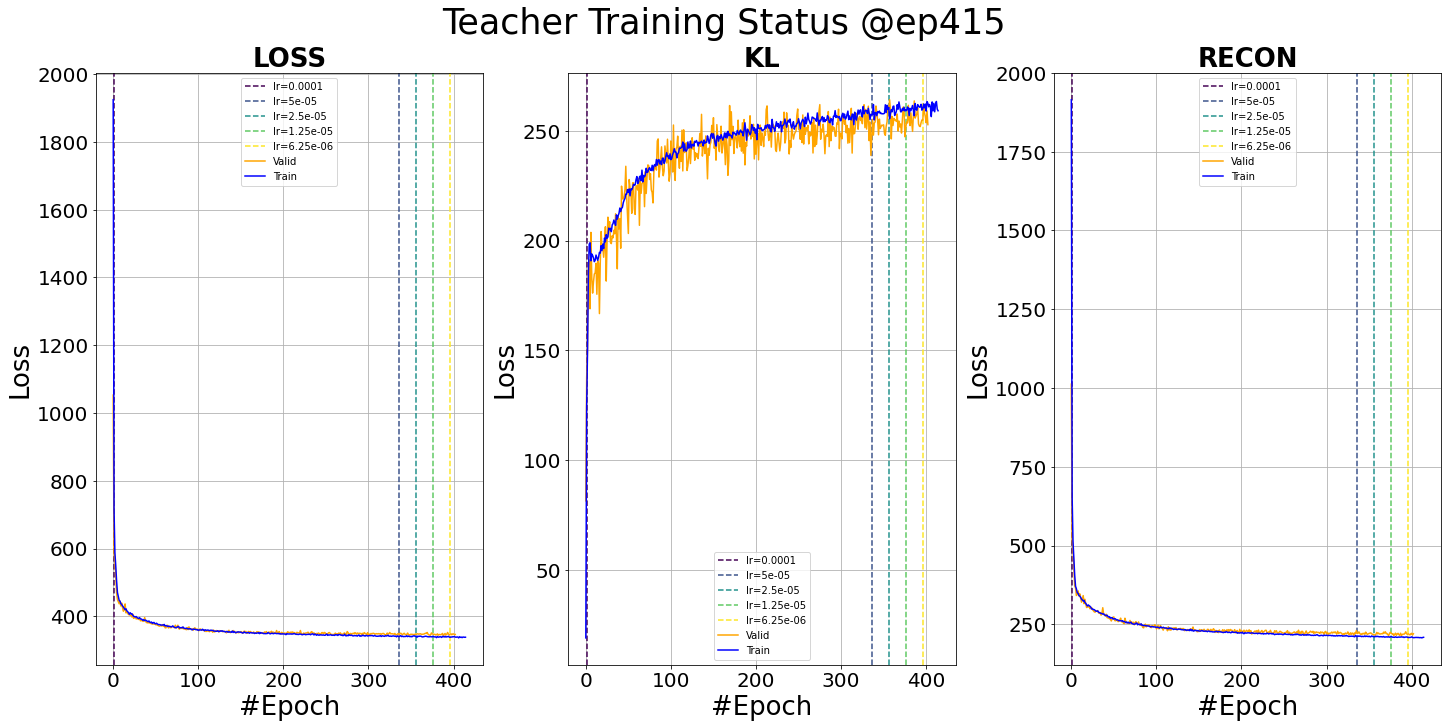

Teacher test: sample=65/68, loss=286.5296    
Test finished. Average loss={'LOSS': 209.37020241425319, 'KL': 4.088088109541466, 'RECON': 207.32615836928872}

Total training time: 18.683308362960815 sec


<Figure size 1440x720 with 0 Axes>

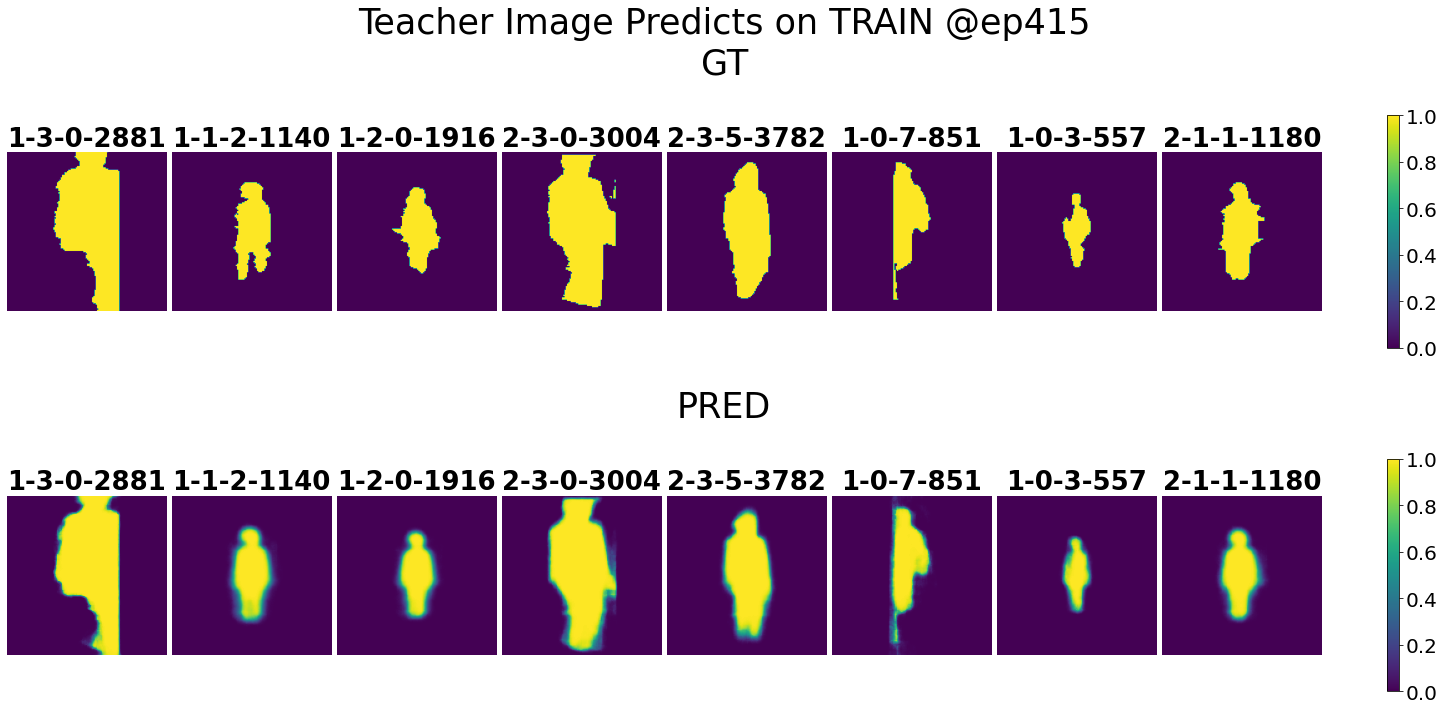

<Figure size 1440x720 with 0 Axes>

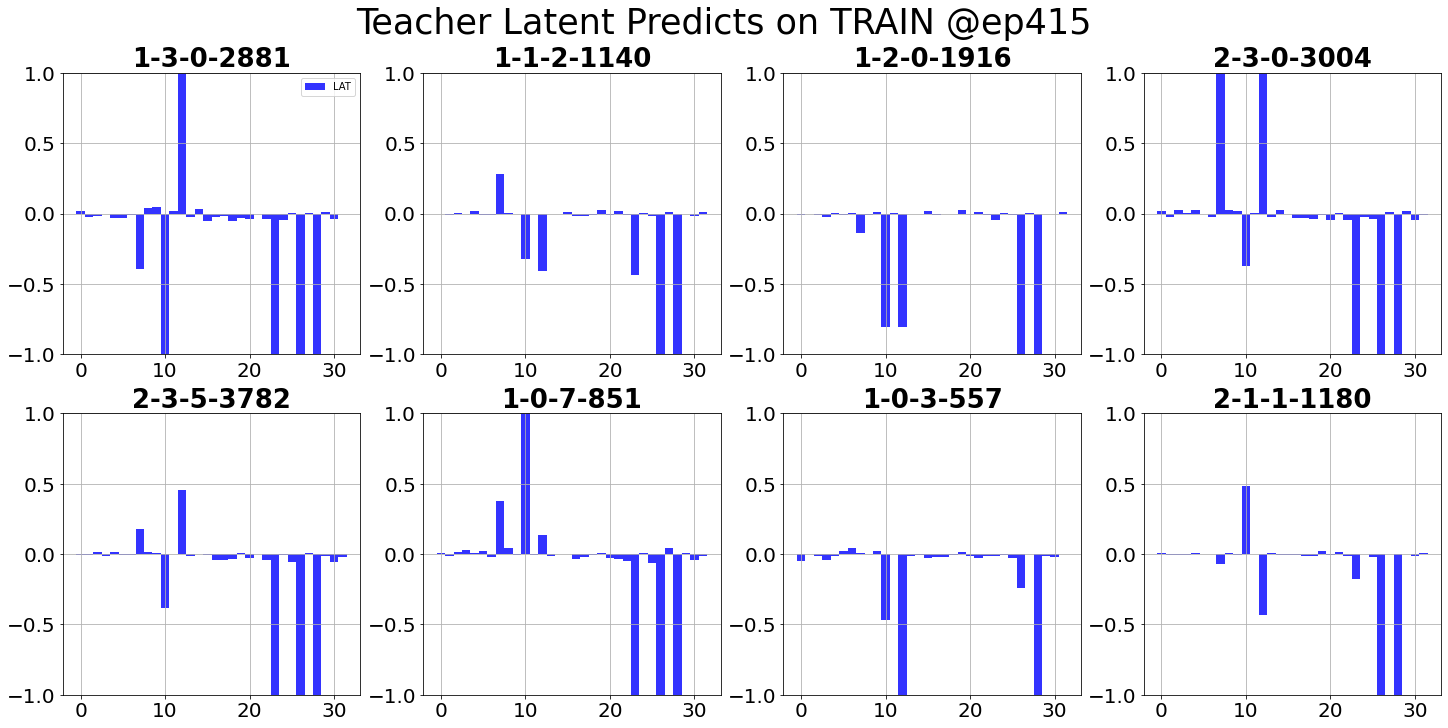

Teacher test: sample=5065/5069, loss=2242.7166    
Test finished. Average loss={'LOSS': 588.2673541257358, 'KL': 3.729718151354042, 'RECON': 586.4024949923237}

Total training time: 47.99424386024475 sec


<Figure size 1440x720 with 0 Axes>

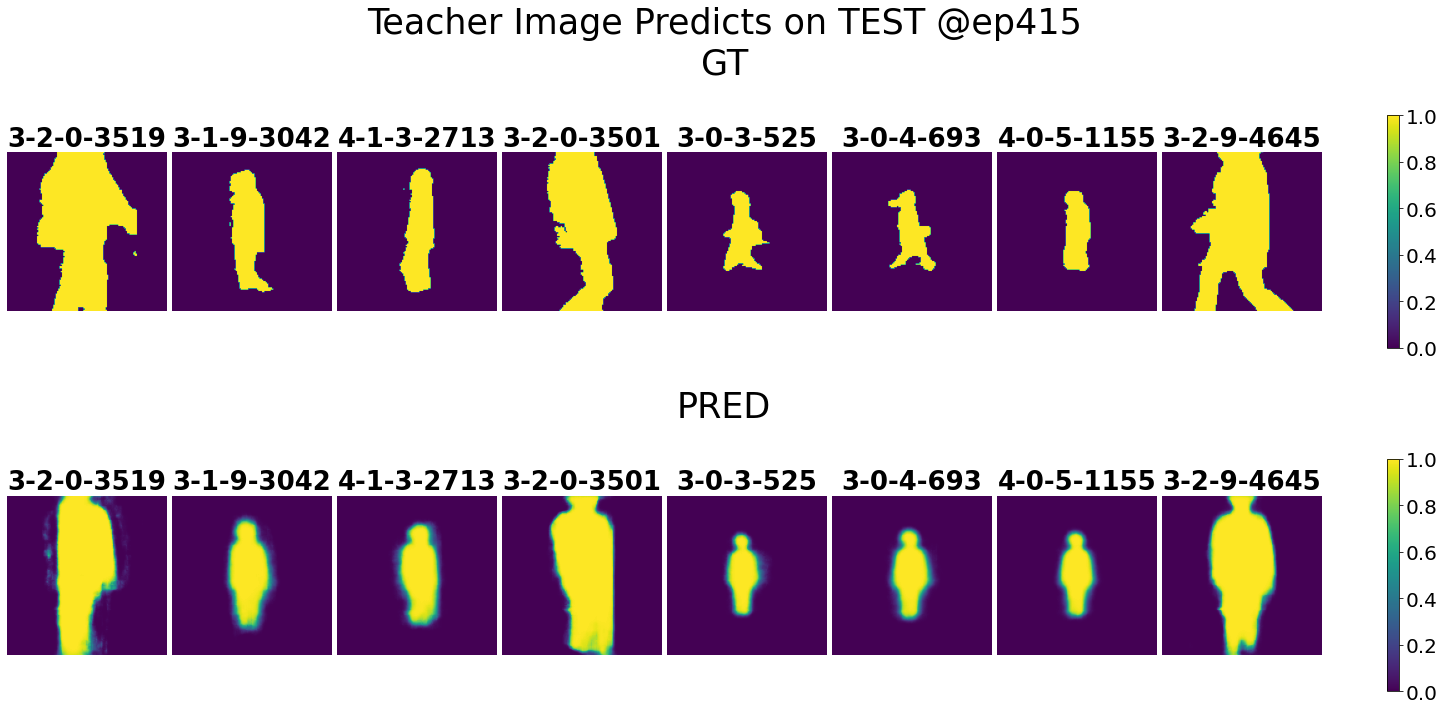

<Figure size 1440x720 with 0 Axes>

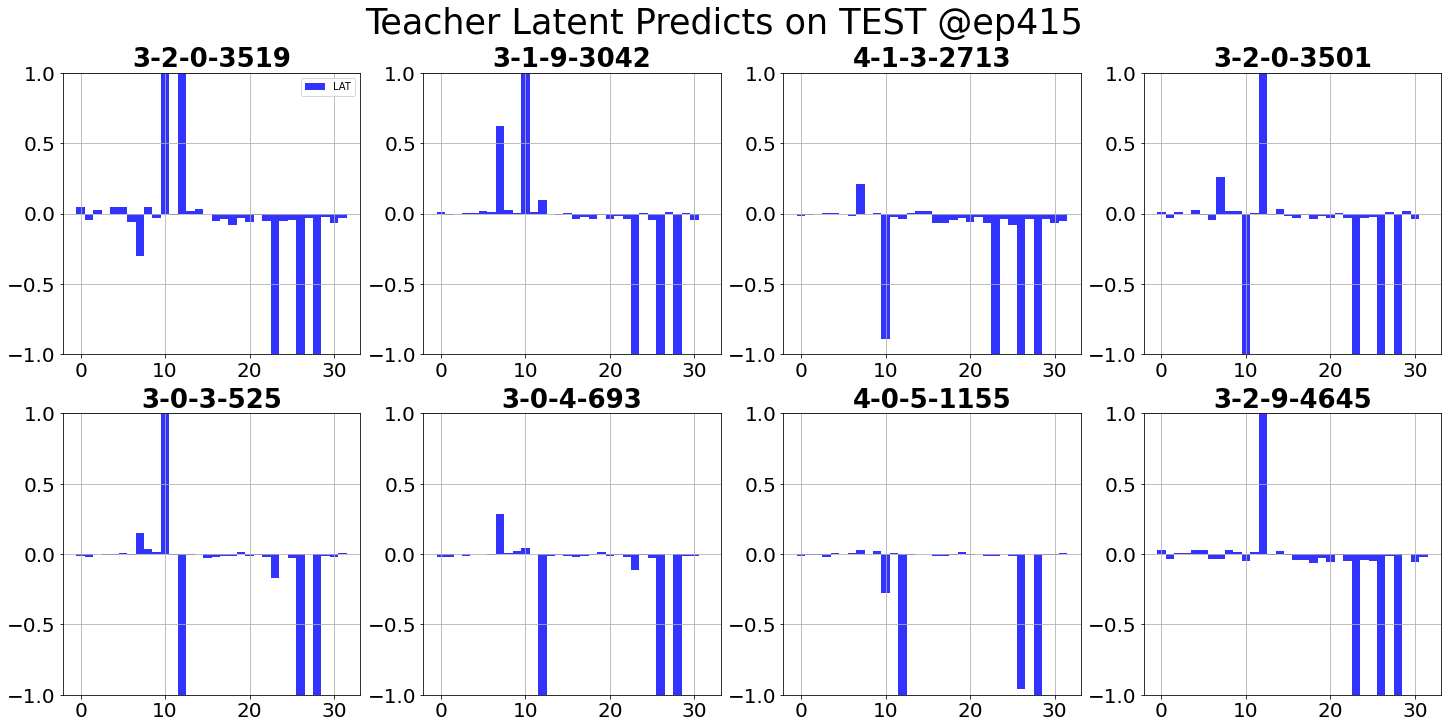

Saving pred including GT, PRED, LAT, TAG...Done

Teacher schedule Completed!


In [16]:
### Scheduler
%matplotlib inline
T_trainer.lr = 1e-4
T_trained = T_trainer.schedule(lr_decay=True)

### Student

In [6]:
torch.cuda.set_device(gpu)
csiencoder = TP.CSIEncoder(lstm_steps=25)
centerdecoder = TP.CenterDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
imgencoder.load_state_dict(torch.load(f"../saved/240527_30_Prop_Teacher_OF/Teacher_IMGENV08C1_best.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240527_30_Prop_Teacher_OF/Teacher_IMGDEV08C1_best.pth"))
#csiencoder.load_state_dict(torch.load(f"../saved/240527_30_Prop/Student_CSIENV08C1_best.pth"))
#centerdecoder.load_state_dict(torch.load(f"../saved/240527_30_Prop/Student_CTRDEV08C1_best.pth"))

S_trainer = TP.StudentTrainer(name='Student', mask=True,
                              networks=[csiencoder, centerdecoder, imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              notion=f"{date}_{run}_{exp}",
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                             )

Student train: epoch=1/999, batch=0/66, loss=0.2008, current best valid loss=inf    
Student train: epoch=1/999, batch=5/66, loss=0.2075, current best valid loss=inf    
Student train: epoch=1/999, batch=10/66, loss=0.1784, current best valid loss=inf    
Student train: epoch=1/999, batch=15/66, loss=0.1596, current best valid loss=inf    
Student train: epoch=1/999, batch=20/66, loss=0.1563, current best valid loss=inf    
Student train: epoch=1/999, batch=25/66, loss=0.1471, current best valid loss=inf    
Student train: epoch=1/999, batch=30/66, loss=0.1739, current best valid loss=inf    
Student train: epoch=1/999, batch=35/66, loss=0.1501, current best valid loss=inf    
Student train: epoch=1/999, batch=40/66, loss=0.1424, current best valid loss=inf    
Student train: epoch=1/999, batch=45/66, loss=0.1598, current best valid loss=inf    
Student train: epoch=1/999, batch=50/66, loss=0.1416, current best valid loss=inf    
Student train: epoch=1/999, batch=55/66, loss=0.1508, cu

<Figure size 432x288 with 0 Axes>

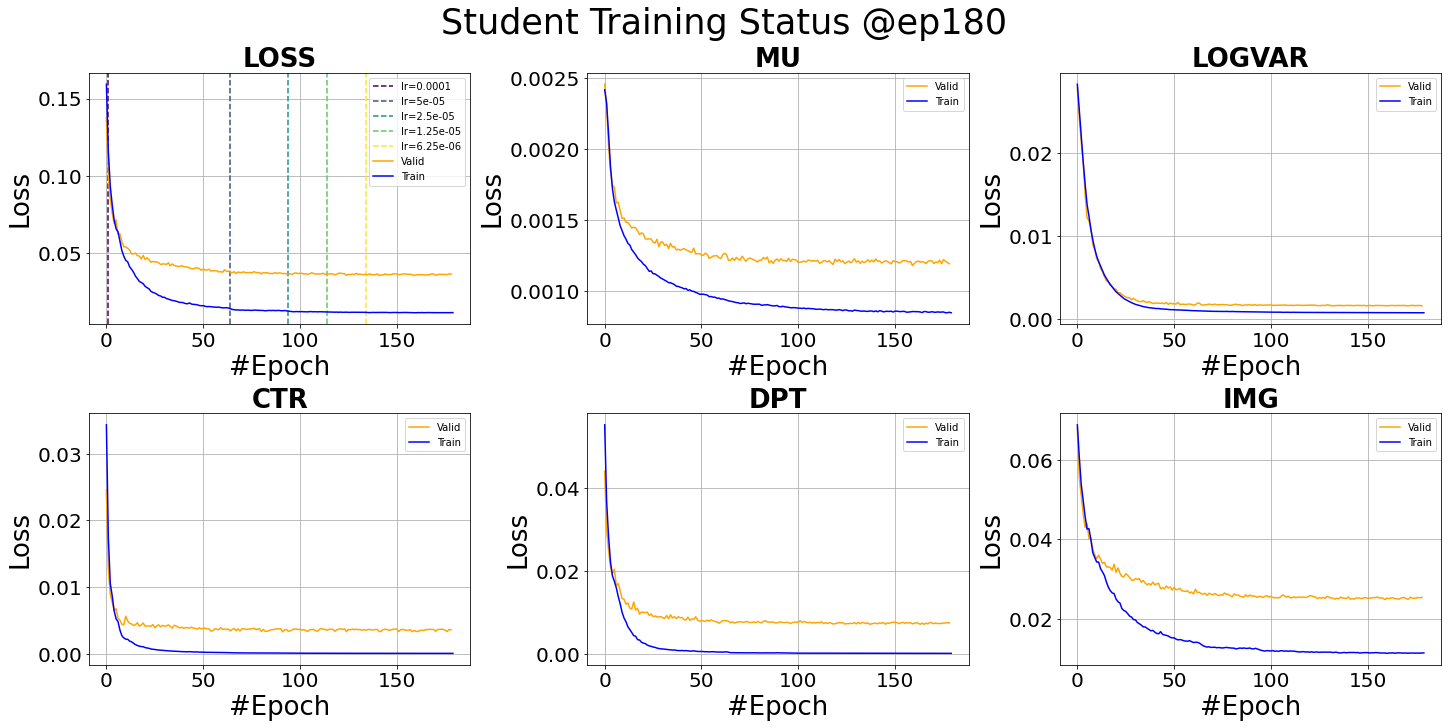

/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Student test: sample=65/66, loss=0.0126    
Test finished. Average loss={'LOSS': 0.01612850935497122, 'MU': 0.05390001495557802, 'LOGVAR': 0.04987666372470516, 'CTR': 3.958355990639242e-05, 'DPT': 7.210988884437322e-05, 'IMG': 0.01070728125997641}

Total training time: 36.11325478553772 sec


<Figure size 1440x720 with 0 Axes>

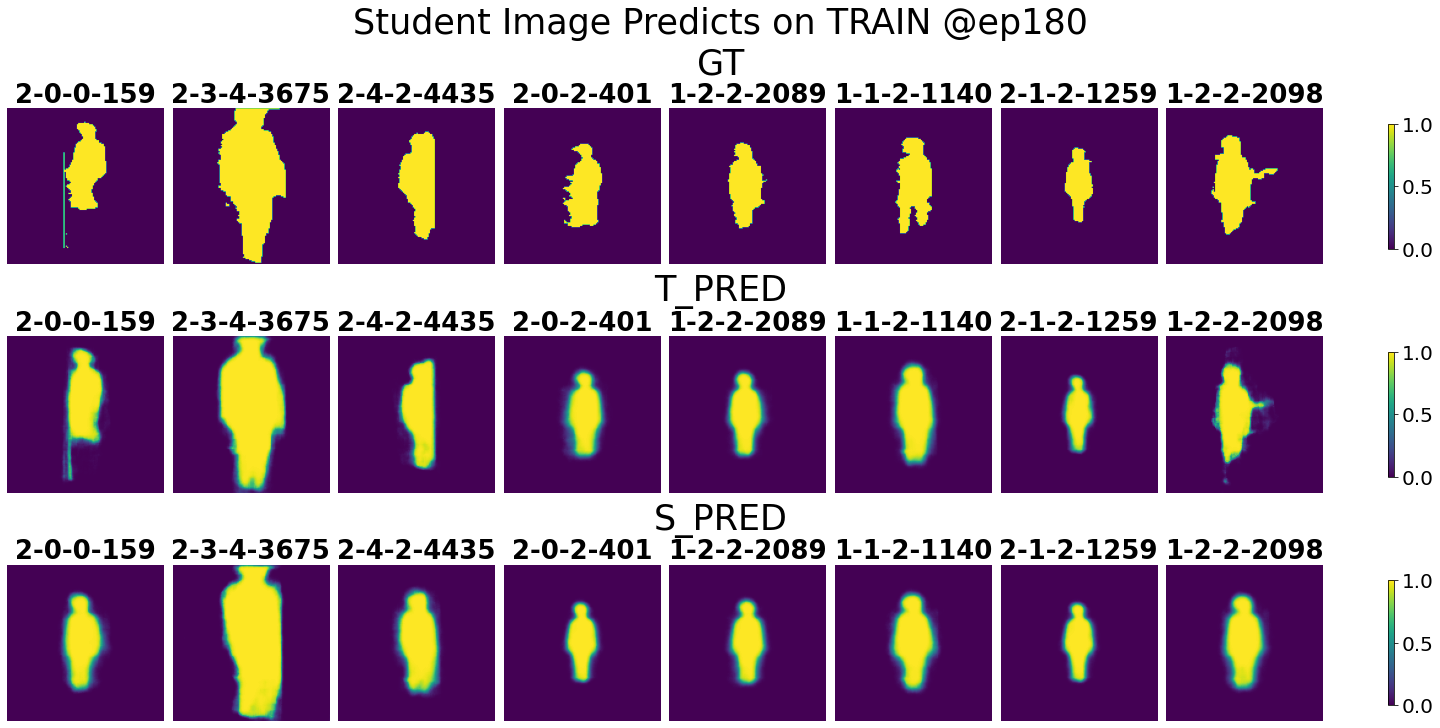

<Figure size 1440x720 with 0 Axes>

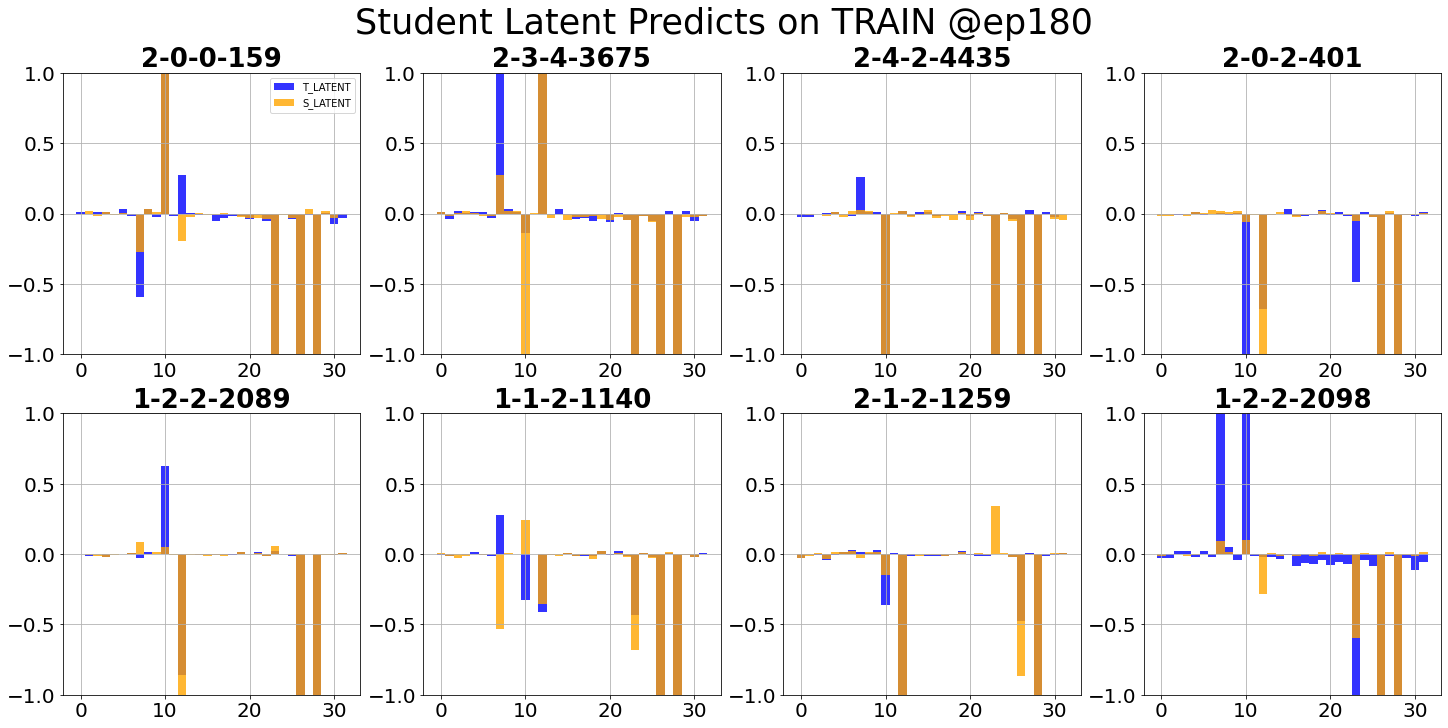

<Figure size 1440x720 with 0 Axes>

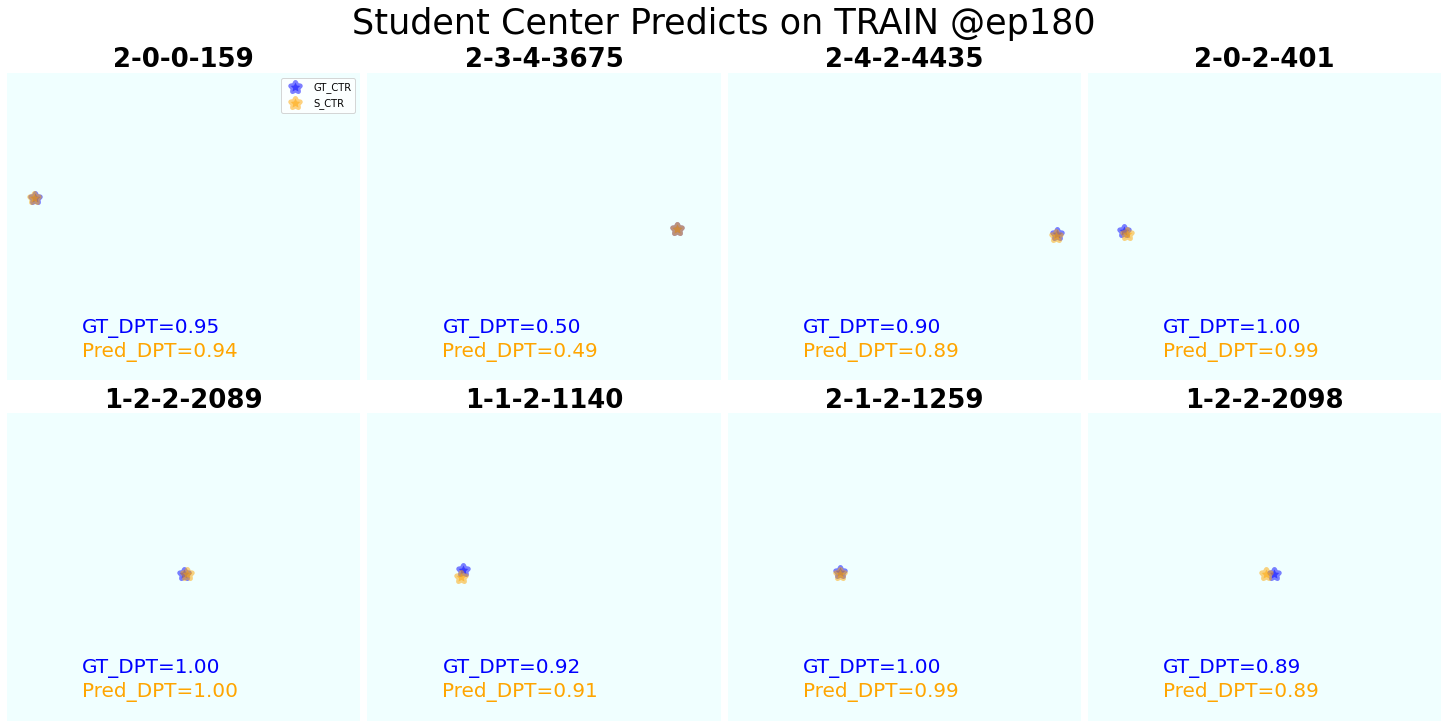

<Figure size 1440x720 with 0 Axes>

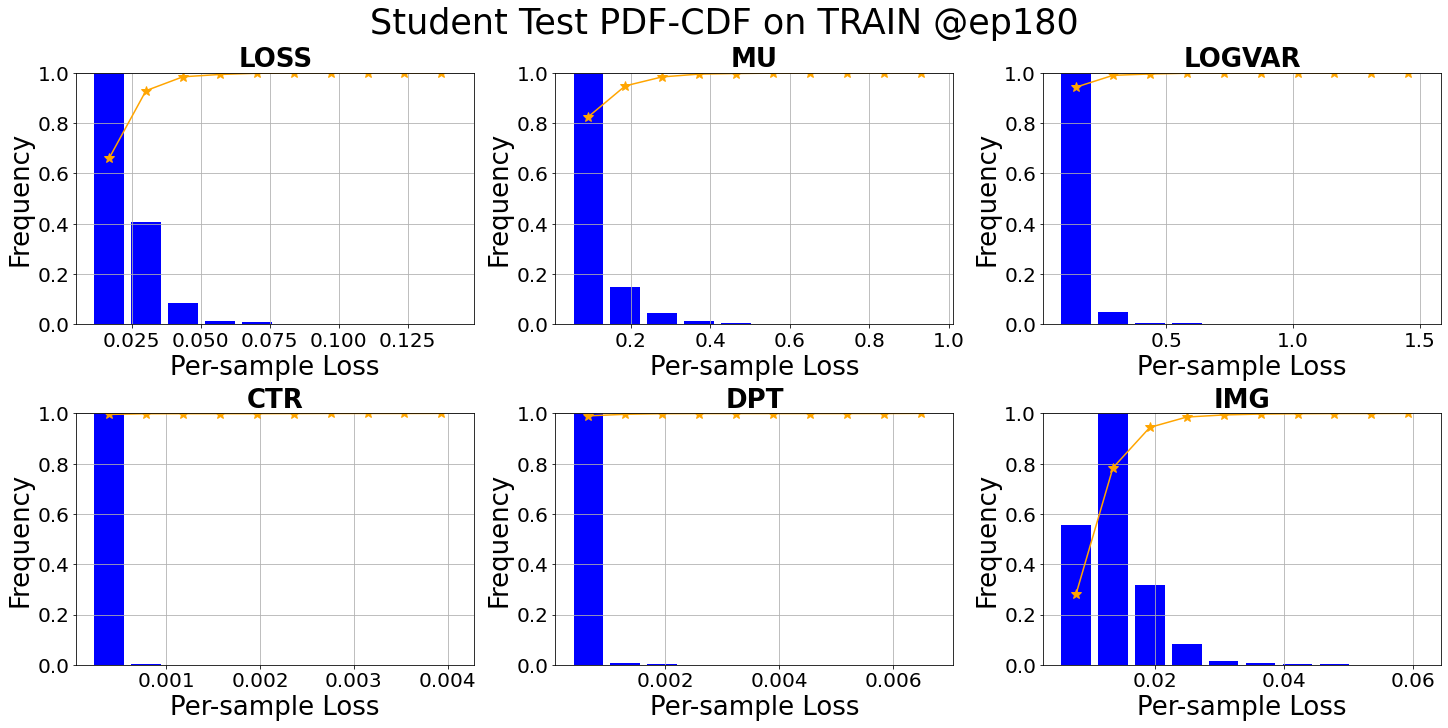

Student test: sample=4950/4953, loss=0.0523    
Test finished. Average loss={'LOSS': 0.0984788708046211, 'MU': 0.13752987988292772, 'LOGVAR': 0.21708015182339155, 'CTR': 0.008684819100990449, 'DPT': 0.025498590878789827, 'IMG': 0.04895146693851947}

Total training time: 70.51559138298035 sec


<Figure size 1440x720 with 0 Axes>

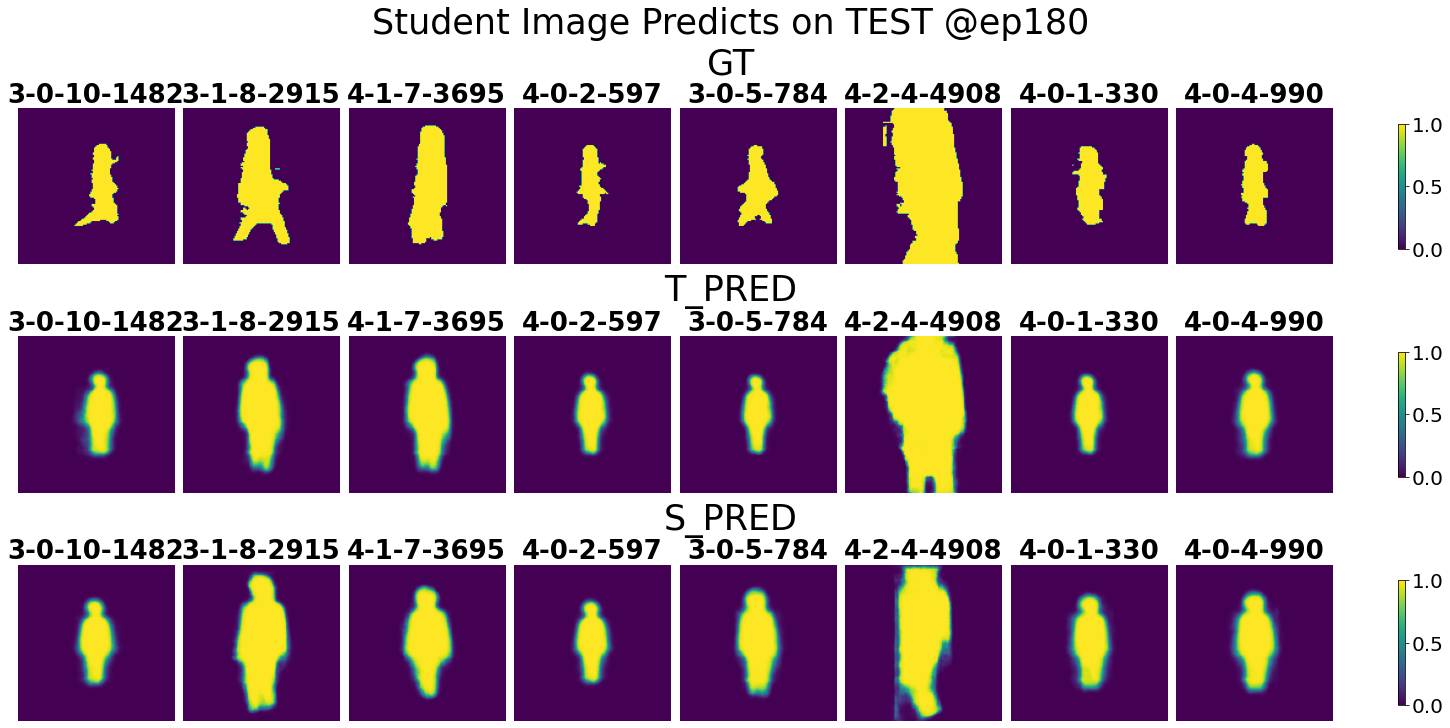

<Figure size 1440x720 with 0 Axes>

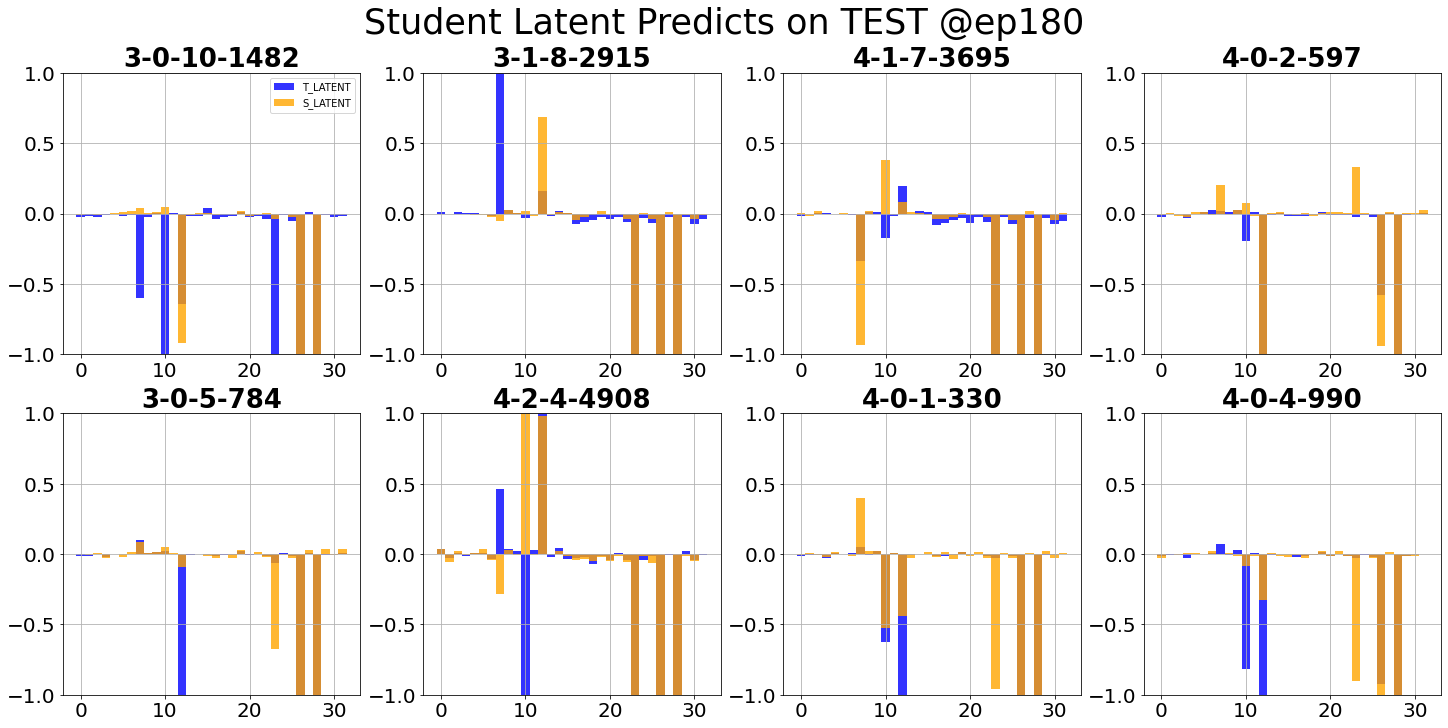

<Figure size 1440x720 with 0 Axes>

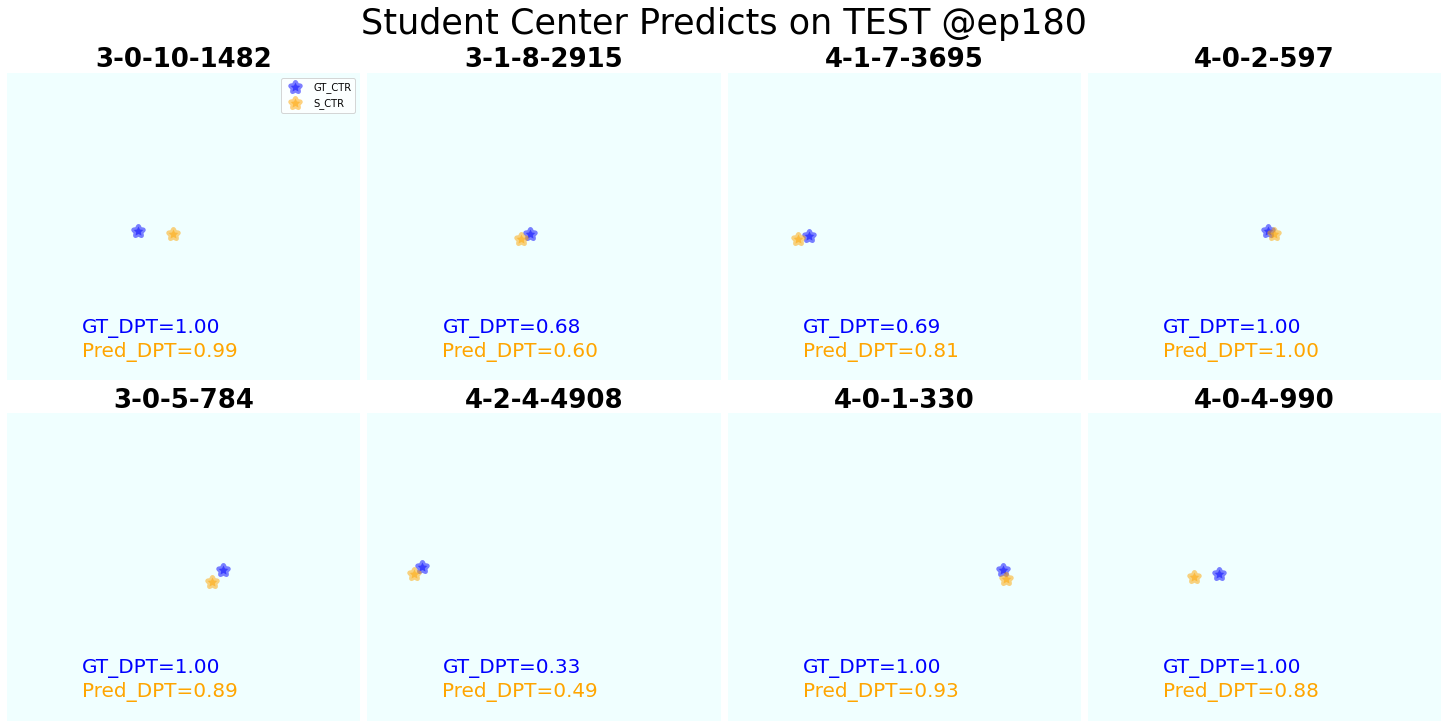

<Figure size 1440x720 with 0 Axes>

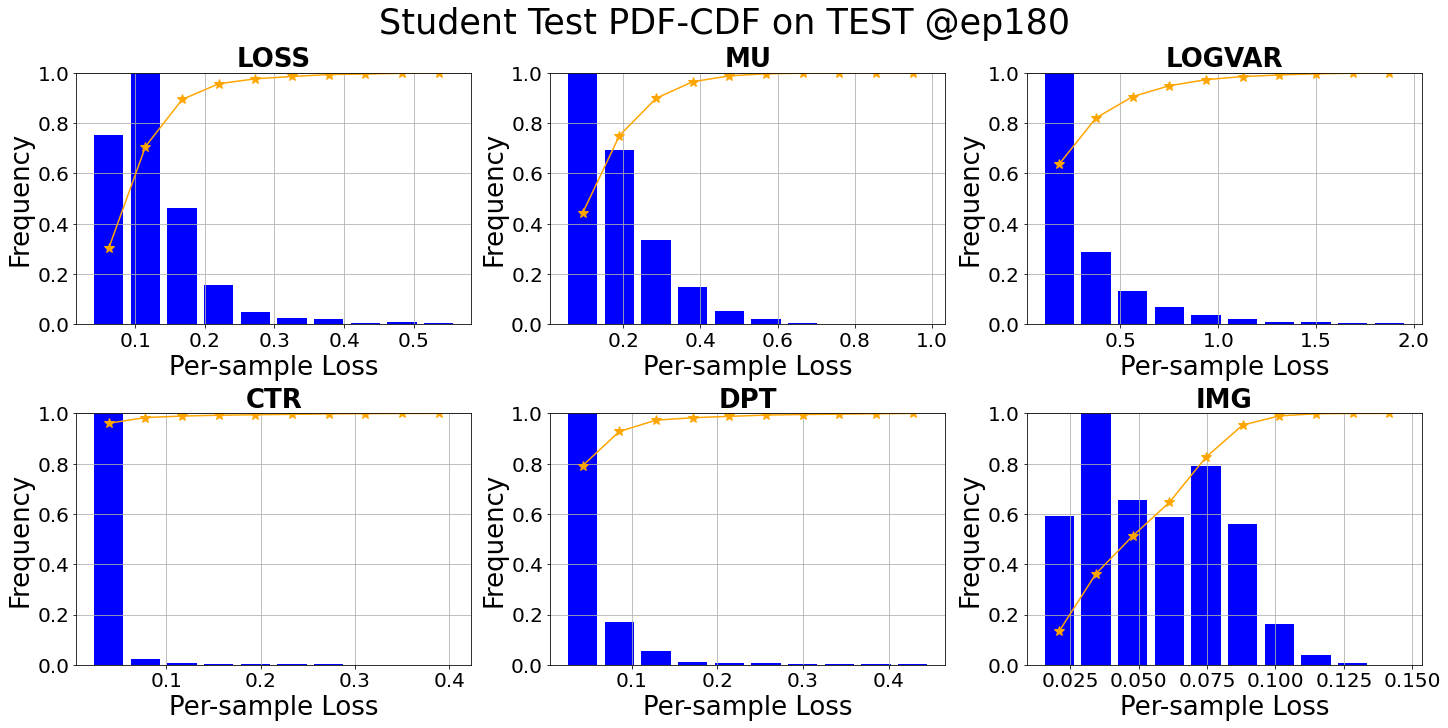

Saving pred: GT...Saving pred: T_PRED...Saving pred: S_PRED...Saving pred: T_LATENT...Saving pred: S_LATENT...Saving pred: GT_CTR...Saving pred: S_CTR...Saving pred: GT_DPT...Saving pred: S_DPT...Saving pred: TAG...Done

Student schedule Completed!


In [7]:
### Scheduler
%matplotlib inline
S_trained = S_trainer.schedule(lr_decay=True, train_module={'csien', 'ctrde'}, eval_module={'imgen', 'imgde'})

In [20]:
print(S_trainer.temp_loss.items())

dict_items([('LOSS', tensor(0.7074, device='cuda:5')), ('MU', tensor(0.4625, device='cuda:5')), ('LOGVAR', tensor(0.9049, device='cuda:5')), ('IMG', tensor(0.0803, device='cuda:5')), ('CTR', tensor(0.0089, device='cuda:5')), ('DPT', tensor(0.0673, device='cuda:5'))])
